# Worked Example: Failure Modeling with EUL + Condition Score (PyMC)

This notebook mirrors `06_failure_modeling_with_eul_and_condition.py` but uses
PyMC to define and fit the Weibull proportional-hazards model.

For each asset:

- `t_i`: observed time (failure or right-censoring)
- `d_i`: event indicator (`1` if failed, `0` if censored)
- `x_i = condition_score - 1`

Hazard model:

$$
h(t \mid c) = h_0(t)\exp\left(\beta(c - 1)\right)
$$

with Weibull baseline:

$$
h_0(t) = \frac{k}{\eta}\left(\frac{t}{\eta}\right)^{k - 1}
$$

Supplier EUL estimates are encoded as priors on `log(eta)`.

In [1]:
from __future__ import annotations

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm

## 1. Generate a 10-year work-order style dataset

In real use, replace this synthetic data with your asset registry + work-order
history.

In [2]:
OBSERVATION_YEARS = 10.0
BASE_INSTALL_DATE = pd.Timestamp("2016-01-01")
RNG = np.random.default_rng(7)
# `0.5` means supplier EUL is interpreted as median life: S(EUL) = 0.5.
EUL_SURVIVAL_PROBABILITY = 0.5


def simulate_asset_history(
    asset_type: str,
    n_assets: int,
    true_k: float,
    true_eta: float,
    true_beta: float,
) -> pd.DataFrame:
    """Simulate first-failure outcomes with right censoring."""
    condition_score = RNG.integers(1, 6, size=n_assets)
    condition_centered = condition_score - 1

    u = RNG.random(n_assets)
    event_time_years = true_eta * (
        -np.log(u) / np.exp(true_beta * condition_centered)
    ) ** (1.0 / true_k)

    event_observed = event_time_years <= OBSERVATION_YEARS
    observed_years = np.minimum(event_time_years, OBSERVATION_YEARS)

    history = pd.DataFrame(
        {
            "asset_id": [f"{asset_type[:5].upper()}-{i:04d}" for i in range(n_assets)],
            "asset_type": asset_type,
            "condition_score": condition_score,
            "event_observed": event_observed.astype(int),
            "observed_years": observed_years,
        }
    )

    history["install_date"] = BASE_INSTALL_DATE
    history["last_observation_date"] = history["install_date"] + pd.to_timedelta(
        history["observed_years"] * 365.25,
        unit="D",
    )
    history["work_order_date"] = pd.NaT
    failure_mask = history["event_observed"] == 1
    history.loc[failure_mask, "work_order_date"] = history.loc[
        failure_mask,
        "last_observation_date",
    ]
    return history


bfly_history = simulate_asset_history(
    asset_type="bfly valves",
    n_assets=420,
    true_k=2.0,
    true_eta=16.0,
    true_beta=0.55,
)

surge_history = simulate_asset_history(
    asset_type="surge valves",
    n_assets=28,
    true_k=2.0,
    true_eta=20.0,
    true_beta=0.55,
)

history = pd.concat([bfly_history, surge_history], ignore_index=True)
history.groupby("asset_type")["event_observed"].agg(["count", "sum"])

,count,sum
asset_type,,
bfly valves,420,290
surge valves,28,13


## 2. PyMC Weibull PH model with optional EUL prior

Likelihood per asset:

$$
\log L_i = d_i \log h_i(t_i) - H_i(t_i)
$$

where:

- $H_i(t) = \left(\frac{t}{\eta}\right)^k \exp\left(\beta x_i\right)$
- $x_i = \mathrm{condition\_score} - 1$ when condition is used, else $0$

`EUL_SURVIVAL_PROBABILITY` controls how supplier EUL is mapped into the prior on
`eta`.

In [3]:
def eul_to_log_eta_prior_mean(
    eul_years: float,
    eul_survival_probability: float = EUL_SURVIVAL_PROBABILITY,
    k_reference: float = 2.0,
) -> float:
    """Map EUL to a prior mean for log(eta)."""
    if not (0.0 < eul_survival_probability < 1.0):
        raise ValueError("eul_survival_probability must be between 0 and 1.")

    eta_from_eul = eul_years / (
        (-np.log(eul_survival_probability)) ** (1.0 / k_reference)
    )
    return float(np.log(eta_from_eul))


def fit_weibull_ph_pymc(
    frame: pd.DataFrame,
    eul_years: float | None = None,
    eul_prior_sigma: float = 0.20,
    eul_survival_probability: float = EUL_SURVIVAL_PROBABILITY,
    use_condition: bool = True,
    beta_prior: tuple[float, float] | None = None,
) -> dict[str, float]:
    """Fit Weibull PH using PyMC and MAP estimation."""
    t = frame["observed_years"].to_numpy(dtype=float)
    t = np.clip(t, 1e-6, None)
    d = frame["event_observed"].to_numpy(dtype=float)
    x = (
        frame["condition_score"].to_numpy(dtype=float) - 1.0
        if use_condition
        else np.zeros_like(t)
    )

    if d.sum() > 0:
        initial_eta = float(np.median(t[d == 1.0]))
    else:
        initial_eta = 20.0

    log_eta_default_mu = float(np.log(max(initial_eta, 1.0)))

    if beta_prior is None:
        beta_prior = (0.0, 2.0)
    beta_mu, beta_sigma = beta_prior

    with pm.Model():
        log_k = pm.Normal("log_k", mu=np.log(1.5), sigma=1.5)

        if eul_years is None:
            log_eta = pm.Normal("log_eta", mu=log_eta_default_mu, sigma=2.0)
        else:
            log_eta = pm.Normal(
                "log_eta",
                mu=eul_to_log_eta_prior_mean(
                    eul_years=eul_years,
                    eul_survival_probability=eul_survival_probability,
                ),
                sigma=eul_prior_sigma,
            )

        beta = pm.Normal("beta", mu=beta_mu, sigma=beta_sigma)

        t_data = pm.Data("t", t)
        d_data = pm.Data("d", d)
        x_data = pm.Data("x", x)

        k = pm.math.exp(log_k)
        eta = pm.math.exp(log_eta)

        cumulative_hazard = ((t_data / eta) ** k) * pm.math.exp(beta * x_data)
        log_hazard = (
            pm.math.log(k)
            - k * pm.math.log(eta)
            + (k - 1.0) * pm.math.log(t_data)
            + beta * x_data
        )

        pm.Potential(
            "survival_loglike",
            pm.math.sum(d_data * log_hazard - cumulative_hazard),
        )

        map_estimate = pm.find_MAP(
            start={"log_k": np.log(1.2), "log_eta": log_eta_default_mu, "beta": 0.0},
            method="L-BFGS-B",
            maxeval=5000,
            progressbar=False,
        )

    k_hat = float(np.exp(np.asarray(map_estimate["log_k"]).item()))
    eta_hat = float(np.exp(np.asarray(map_estimate["log_eta"]).item()))
    beta_hat = float(np.asarray(map_estimate["beta"]).item())

    return {
        "k": k_hat,
        "eta": eta_hat,
        "beta": beta_hat,
        "hazard_ratio_per_condition_step": float(np.exp(beta_hat)),
        "median_life_years": float(eta_hat * (np.log(2.0) ** (1.0 / k_hat))),
    }


def fit_weibull_no_condition_pymc(
    frame: pd.DataFrame,
    eul_years: float | None = None,
    eul_prior_sigma: float = 0.20,
    eul_survival_probability: float = EUL_SURVIVAL_PROBABILITY,
) -> dict[str, float]:
    """Fit Weibull baseline model with no condition effect."""
    return fit_weibull_ph_pymc(
        frame=frame,
        eul_years=eul_years,
        eul_prior_sigma=eul_prior_sigma,
        eul_survival_probability=eul_survival_probability,
        use_condition=False,
        beta_prior=(0.0, 0.05),
    )

## 3. Fit rich vs sparse asset types

Workflow:

1. Without EUL and without condition
2. With EUL only
3. With condition only
4. With EUL + condition

In [4]:
SUPPLIER_EUL_YEARS = {
    "bfly valves": 15.0,
    "surge valves": 12.0,
}

bfly_models = {
    "Without EUL & condition": fit_weibull_no_condition_pymc(
        bfly_history,
        eul_years=None,
    ),
    "With EUL only": fit_weibull_no_condition_pymc(
        bfly_history,
        eul_years=SUPPLIER_EUL_YEARS["bfly valves"],
    ),
    "With condition only": fit_weibull_ph_pymc(
        bfly_history,
        eul_years=None,
    ),
    "With EUL + condition": fit_weibull_ph_pymc(
        bfly_history,
        eul_years=SUPPLIER_EUL_YEARS["bfly valves"],
    ),
}

surge_models = {
    "Without EUL & condition": fit_weibull_no_condition_pymc(
        surge_history,
        eul_years=None,
    ),
    "With EUL only": fit_weibull_no_condition_pymc(
        surge_history,
        eul_years=SUPPLIER_EUL_YEARS["surge valves"],
    ),
    "With condition only": fit_weibull_ph_pymc(
        surge_history,
        eul_years=None,
    ),
    "With EUL + condition": fit_weibull_ph_pymc(
        surge_history,
        eul_years=SUPPLIER_EUL_YEARS["surge valves"],
    ),
}

all_models = {
    "bfly valves": bfly_models,
    "surge valves": surge_models,
}

results_rows = []
for asset_type, model_set in all_models.items():
    for model_name, params in model_set.items():
        results_rows.append(
            {
                "asset_type": asset_type,
                "model": model_name,
                **params,
            }
        )

results = pd.DataFrame(results_rows)
summary_counts = history.groupby("asset_type", as_index=False).agg(
    n_assets=("asset_id", "count"),
    failures=("event_observed", "sum"),
)
results.merge(summary_counts, on="asset_type").round(3)

,asset_type,model,k,eta,beta,hazard_ratio_per_condition_step,median_life_years,n_assets,failures
0,bfly valves,Without EUL & condition,1.768,9.002,0.000,1.000,7.317,420,290
1,bfly valves,With EUL only,1.760,9.180,0.000,1.000,7.454,420,290
2,bfly valves,With condition only,2.139,16.612,0.644,1.904,13.996,420,290
3,bfly valves,With EUL + condition,2.134,16.770,0.649,1.913,14.124,420,290
4,surge valves,Without EUL & condition,1.936,12.377,0.000,1.000,10.243,28,13
5,surge valves,With EUL only,1.832,13.288,0.000,1.000,10.878,28,13
6,surge valves,With condition only,2.244,26.602,0.706,2.025,22.594,28,13
7,surge valves,With EUL + condition,2.446,17.143,0.450,1.568,14.758,28,13


## 4. Worked probability example

$$
P\left(t < T \le t+1 \mid T > t, c\right)
= 1 - \exp\left(-\left(H(t+1,c) - H(t,c)\right)\right)
$$

In [5]:
def conditional_failure_probability(
    model: dict[str, float],
    age_now: float,
    horizon: float,
    condition_score: int,
) -> float:
    """Failure probability over a horizon, conditional on survival to age_now."""
    k = model["k"]
    eta = model["eta"]
    beta = model["beta"]
    x = condition_score - 1.0

    def cumulative_hazard(age: float) -> float:
        return ((age / eta) ** k) * np.exp(beta * x)

    delta_h = cumulative_hazard(age_now + horizon) - cumulative_hazard(age_now)
    return float(1.0 - np.exp(-delta_h))


rows = []
for condition in [1, 2, 3, 4, 5]:
    rows.append(
        {
            "asset_type": "bfly valves",
            "model": "With EUL + condition",
            "condition_score": condition,
            "p_fail_next_year": conditional_failure_probability(
                bfly_models["With EUL + condition"],
                age_now=9.0,
                horizon=1.0,
                condition_score=condition,
            ),
        }
    )
    rows.append(
        {
            "asset_type": "surge valves",
            "model": "With condition only",
            "condition_score": condition,
            "p_fail_next_year": conditional_failure_probability(
                surge_models["With condition only"],
                age_now=9.0,
                horizon=1.0,
                condition_score=condition,
            ),
        }
    )
    rows.append(
        {
            "asset_type": "surge valves",
            "model": "With EUL + condition",
            "condition_score": condition,
            "p_fail_next_year": conditional_failure_probability(
                surge_models["With EUL + condition"],
                age_now=9.0,
                horizon=1.0,
                condition_score=condition,
            ),
        }
    )

probability_table = pd.DataFrame(rows)
probability_table["p_fail_next_year"] = probability_table["p_fail_next_year"].map(
    lambda value: round(100.0 * value, 2)
)
probability_table

,asset_type,model,condition_score,p_fail_next_year
0,bfly valves,With EUL + condition,1,6.46
1,surge valves,With condition only,1,2.32
2,surge valves,With EUL + condition,1,5.90
3,bfly valves,With EUL + condition,2,12.00
4,surge valves,With condition only,2,4.63
5,surge valves,With EUL + condition,2,9.09
6,bfly valves,With EUL + condition,3,21.69
7,surge valves,With condition only,3,9.16
8,surge valves,With EUL + condition,3,13.89
9,bfly valves,With EUL + condition,4,37.35


## 5. Curves by model variant for both asset types

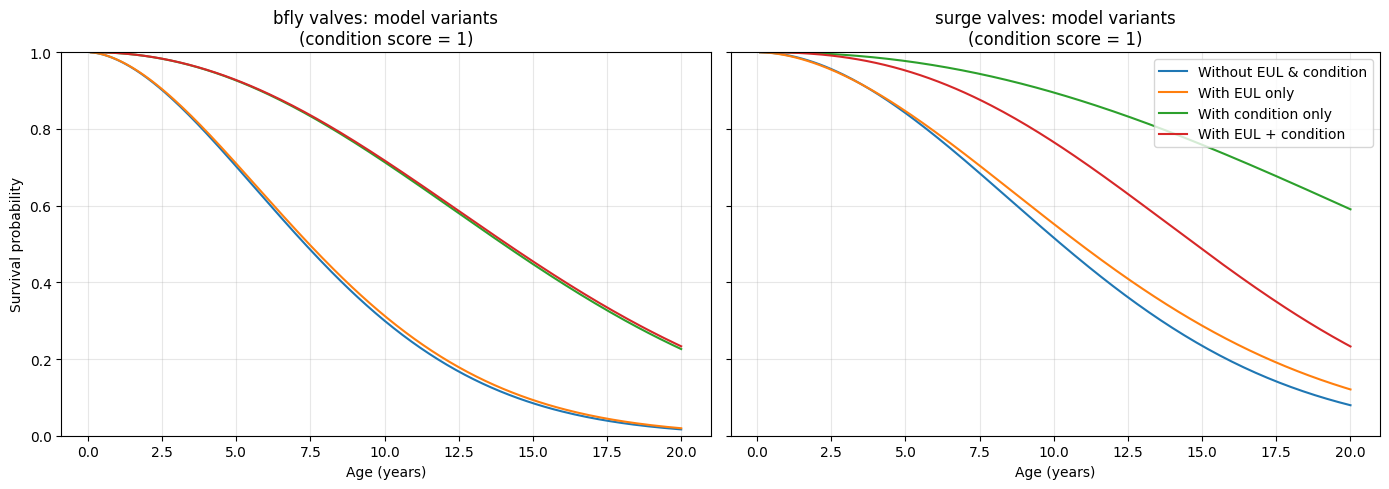

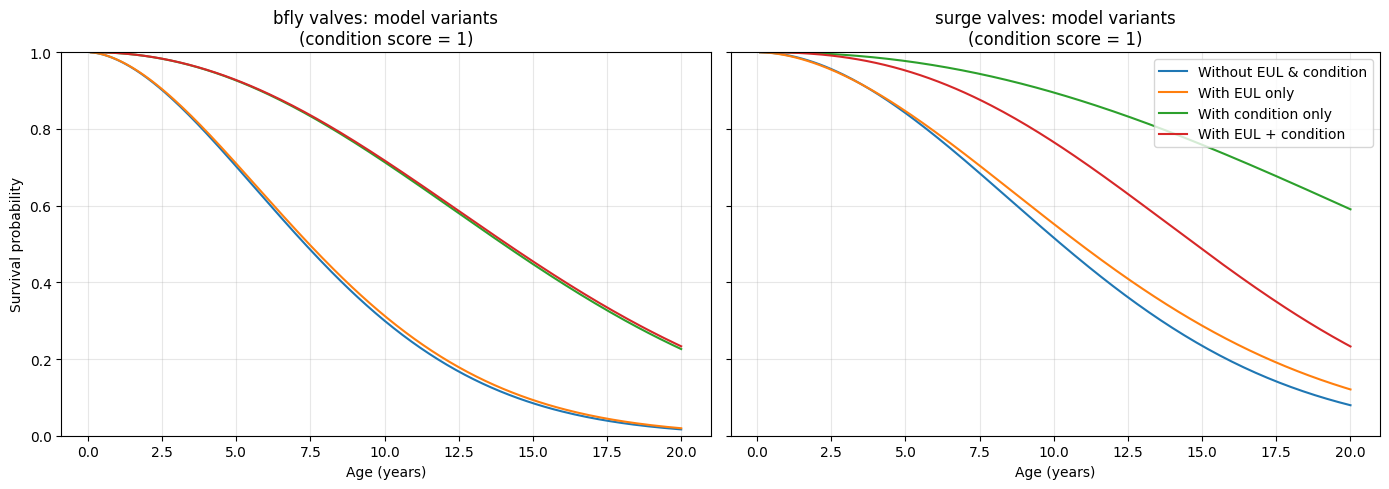

In [7]:
CONDITIONS_FOR_CURVES = (1, 4)
ages = np.linspace(0.1, 20.0, 200)


def survival_curve(
    model: dict[str, float], ages_years: np.ndarray, condition: int
) -> np.ndarray:
    k = model["k"]
    eta = model["eta"]
    beta = model["beta"]
    x = condition - 1.0
    return np.exp(-((ages_years / eta) ** k) * np.exp(beta * x))


asset_types = ("bfly valves", "surge valves")
fig, axes = plt.subplots(
    len(CONDITIONS_FOR_CURVES),
    len(asset_types),
    figsize=(14, 9),
    sharex=True,
    sharey=True,
)
for row, condition in enumerate(CONDITIONS_FOR_CURVES):
    for col, asset_type in enumerate(asset_types):
        ax = axes[row, col]
        for model_name, model in all_models[asset_type].items():
            ax.plot(ages, survival_curve(model, ages, condition), label=model_name)
        ax.set_title(f"{asset_type}\n(condition score = {condition})")
        ax.grid(alpha=0.3)

for col, asset_type in enumerate(asset_types):
    axes[-1, col].set_xlabel("Age (years)")
for row in range(len(CONDITIONS_FOR_CURVES)):
    axes[row, 0].set_ylabel("Survival probability")

axes[0, 0].set_ylim(0, 1)
axes[0, -1].legend(loc="upper right")
fig.tight_layout()
fig

## Summary

- This version uses PyMC for model specification and MAP fitting.
- Right-censoring and condition effects are represented directly in the model
  log-likelihood.
- Supplier EUL enters as a prior on `log(eta)` and has larger impact when data
  is sparse (for example `surge valves`).